MIE1517 - Group Project

Group 7

1. Avinash Mudireddy
2. Nagarajan Jayaraman
3. Nehel Malhotra

Experimental results can be found here: https://github.com/nehelmalhotra/Music-Genre-Detection

In [1]:
# Install and import required libraries
!pip install pydub audiomentations

In [2]:
import torch
import torchaudio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pydub import AudioSegment


import os
import csv
from scipy.io.wavfile import write
import IPython
from getpass import getpass
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift,TimeMask
import urllib
import librosa

from torch.utils.data import random_split
random_seed = 42
torch.manual_seed(random_seed);
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


from tqdm import tqdm

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torchaudio.datasets.utils import download_url
#from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.autograd import Variable

### Obtain the dataset

In [4]:
# The GTZAN dataset required for this classification task is available 
# on torch_audio and can be downloaded as follows:
dataset = GTZAN(root=".", download=True)

  0%|          | 0.00/1.14G [00:00<?, ?B/s]

In [5]:
data_dir='/content/genres'
list_files=os.listdir(data_dir)
classes=[]
songs_per_class = {}
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  counter = 0
  if os.path.isdir(name):
    classes.append(file)
    for songs in os.listdir(name):
      counter+=1
    songs_per_class[file] = counter    
classes

['metal',
 'country',
 'pop',
 'rock',
 'reggae',
 'classical',
 'disco',
 'jazz',
 'hiphop',
 'blues']

In [6]:
songs_per_class

{'blues': 100,
 'classical': 100,
 'country': 100,
 'disco': 100,
 'hiphop': 100,
 'jazz': 100,
 'metal': 100,
 'pop': 100,
 'reggae': 100,
 'rock': 100}

In [10]:
waveform,samplerate,label= dataset[0]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

shape of waveform torch.Size([1, 661794]), sample rate with 22050, label is blues 


About the dataset: 

The dataset consists of 100 songs each for 10 different music genres. These songs are all 30sec long and contain both vocals and instruments.

### Feature Extraction

Audio files such as .wav and .mp3 files contain audio signals that are represented by a wave. These audio files have two important parameters, the sampling rate which is how frequently the magnitute of the wave is captured and the bytes which is how much information is captured each time.

More information and analysis of this can be found here: 


The GTZAN dataset consists of single-channel 16-bit audio data with a sampling rate of 22.05 kHz. However the magnitude of the wave themselves does not contain sufficient information and features need to be extracted from it in order to train a machine learning model.

We will be focusing of the following features and using these for model training:     

1. Chromoa STFT
2. Amplitude Envelope
3. Amplitude RMSE
4. Spectral Centroid
5. Spectral Bandwidth
6. Spectral Rolloff
7. Spectral Contrast
8. Zero Crossing Rate
9. MFCC

A detailed description and analysis of each feature is provided in the following notebook:

In this section we will be focusing on presenting MFCC's.

Mel Frequency Cepstral Coefficients (MFCCs) of a signal are a small set of features which concisely describe the overall shape of a spectral envelope. Sincw MFCC's capture short-duration musical textures, these can be really useful when dealing with the music genre classification problem.

In [7]:
## Extracting MFCC's and other features for an audio dataset


## The following funcion generates and saves a CSV file with all the audio information

def create_features(file_name,num_mfcc):
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, num_mfcc+1):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()

    file = open(file_name, 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
    genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

    for g in tqdm(genres):
        for filename in os.listdir(f'/content/genres/{g}'):
            try:
              songname = f'/content/genres/{g}/{filename}'
              # print(songname)
              y, sr = librosa.load(songname, mono=True, duration=30)
              chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
              rmse = librosa.feature.rms(y=y)
              spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
              spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
              rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
              # print(rolloff)
              zcr = librosa.feature.zero_crossing_rate(y)
              mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
              to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
              for e in mfcc:
                  to_append += f' {np.mean(e)}'
              to_append += f' {g}'
              file = open(file_name, 'a', newline='')
              with file:
                  # print("Writing to file")
                  writer = csv.writer(file)
                  writer.writerow(to_append.split())
            except (RuntimeError,IsADirectoryError):
              pass

In [8]:
create_features('mfcc_20.csv',20)

100%|██████████| 10/10 [06:57<00:00, 41.74s/it]


### Data Splitting

Deep learning and neural networks have been known about for years but the wide adoption of these have also started a few years ago. This is because these techniques are very reliant on the quality and also quantity of data. 

Data quantity when dealing with audio data can be increased by splitting an audio files into multiple segments. This also ensures that different sections of a given song also still percieved as a given genre.

In [6]:
def export_to_dir(file_name,chopped_audio,counter):
  for audio_data in chopped_audio:
    save_file_name=file_name + '_' + str(counter)+'.wav'
    # export_path=os.path.join(new_dir,file_name)
    audio_data.export(save_file_name,format="wav")
    # print(type(abc))
    int(counter)
    counter+=1  
  return counter  

def chop_audio(audio_file,segment_size,max_size):  #All file are not even so we cut it in same size using max_size and provide segment size using segment
  audio_data = AudioSegment.from_file(audio_file)
  cut_audio_data = audio_data[:max_sec]
  chopped_audio=[x for x in cut_audio_data[::segment]]
  return chopped_audio

  
max_sec=25 * 1000 # max size of audio we take (for 25 sec)
segment=5 * 1000  # segment size(for 5 sec)
new_dir='/content/data'
counter=0

In [7]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
features=[]
labels=[]
file_names = []
for g in tqdm(genres):
    counter = 0
    directory = f'/content/data_seg/{g}'
    if not os.path.exists(directory):
        os.makedirs(directory)
    for filename in os.listdir(f'/content/genres/{g}'):
        songname = f'/content/genres/{g}/{filename}'
        chopped_audio=chop_audio(songname,segment,max_sec)
        file_name = directory = f'/content/data_seg/{g}/{g}'
        # print(file_name)
        counter=export_to_dir(file_name,chopped_audio,counter)

100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


### Data Augmentations

Data augmentation can not only be used to create additional data, but it also introduces variations and noise to the exisiting data which can help a machine learning model to generalize better. For our audio dataset, we will be using the following augmentations, each with a 30% probability:     

1. Introduce gaussian noise.
2. Time stretching. 
3. Shifting the pitch.
4. Make a randomly chosen part of the audio silent.

In [8]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.05, p=0.3),
    TimeStretch(min_rate=0.5, max_rate=1, p=0.3),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.3),
    TimeMask(min_band_part=0.0, max_band_part=0.1,p=0.3)
])

In [9]:
def make_augmentations(file_name,save_dir):
    w,samplerate = librosa.load(file_name)
    augmented_samples = augment(samples=w, sample_rate=22050)
    # os.chdir(save_dir)
    write(os.path.join(save_dir,file_name), samplerate, augmented_samples.astype(np.float32))

audio_data_path = "/content/data_seg"
aug_data_path = "/content/data_seg_aug"
if not os.path.exists(aug_data_path):
    os.mkdir(aug_data_path)

for x in tqdm(classes):
  source_path=os.path.join(audio_data_path, x)
  dest_path = os.path.join(aug_data_path, x)
  if not os.path.exists(dest_path):
      os.mkdir(dest_path)
  list_file=os.listdir(source_path)
  os.chdir(source_path)
  for file_name in list_file:
    make_augmentations(file_name,dest_path)

100%|██████████| 10/10 [05:14<00:00, 31.44s/it]


### Baseline Model

A baselines model is used as a reference point as something that is easy to implement and train. For this multiclass classification problem, we will be using a SVM model as the baseline.

**Note:** Due to the high training times for SVM with the segmneted dataset, an augmented dataset of the original 30 sec songs is used to extract the features and used for training. The dataset looks as follows:

In [15]:
df = pd.read_csv('/content/mfcc_20.csv')

In [16]:
df.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00027.wav,0.288721,0.095768,1391.367710,1494.892439,2811.108002,0.072359,-228.227997,130.353546,-23.297619,70.173668,1.137059,7.609718,0.915007,1.989320,-6.161291,-9.390744,-2.566143,-4.523861,-0.266735,0.181102,-1.513058,1.460951,-6.976431,-8.318999,4.241007,0.979682,blues
1,blues.00096.wav,0.260574,0.051349,1132.340629,1582.492047,2065.479177,0.048314,-314.582794,139.926743,11.865850,30.113317,-7.549764,14.914179,-2.699563,6.707931,-6.391602,2.819350,-11.715414,2.077480,-11.442501,-9.504389,-15.185495,-9.355572,-5.672771,1.564773,0.890936,-7.960377,blues
2,blues.00014.wav,0.329163,0.066981,1172.065695,1705.817502,2344.952487,0.045046,-305.705170,113.060928,12.118721,45.030003,17.769758,14.579918,4.166732,0.225274,-7.021748,13.644271,8.934528,1.298479,5.954477,8.543867,1.117664,0.591559,0.057474,-3.712341,-1.004448,-1.802434,blues
3,blues.00099.wav,0.370279,0.105061,1538.817338,1703.507382,3175.272466,0.074799,-177.165863,136.221588,-26.915182,36.376289,-18.760828,20.909632,-1.778092,3.013012,-5.600873,5.638467,-8.117091,5.642528,-10.790227,-2.416264,-6.943611,-2.507238,-5.203642,-3.407661,-3.246502,-2.681821,blues
4,blues.00032.wav,0.276317,0.101234,1309.424564,1882.919367,2764.099953,0.039393,-288.801727,105.899620,18.791321,23.688492,5.705112,25.549154,-13.467205,12.424733,-11.943818,1.575499,-15.636262,-6.665247,-11.718801,-2.952338,-7.380499,-15.693589,-10.958548,-10.877396,-18.504187,-19.110741,blues


In [17]:
spectra = df.iloc[:,1:]
spectra = spectra.drop('label',axis=1)
label = df['label']

In [18]:
spectra.shape

(1000, 26)

In [19]:
x_train,x_test,y_train,y_test = train_test_split(spectra,label,test_size = 0.2,stratify = label)

In [20]:
encoded = {'pop':0,'jazz':1,'blues':2,'reggae':3,'classical':4,'metal':5,'country':6,'hiphop':7,'rock':8,'disco':9}
y_train = y_train.map(encoded)
y_test = y_test.map(encoded)

In [21]:
clf = SVC(C=0.1, cache_size=200, class_weight=None, coef0=1000.0,
          decision_function_shape='ovr', degree=2, gamma=0.0001, kernel='linear',
          max_iter=-1, probability=False, random_state=None, shrinking=True,
          tol=0.001, verbose=False)

clf.fit(x_train, y_train)

SVC(C=0.1, coef0=1000.0, degree=2, gamma=0.0001, kernel='linear')

In [22]:
train_predictions = clf.predict(x_train)
test_predictions = clf.predict(x_test)

print("Train Accuracy: " ,accuracy_score(train_predictions, y_train))
print("Test Accuracy:" ,accuracy_score(test_predictions, y_test))

Train Accuracy:  0.79
Test Accuracy: 0.56


### Neural Network Model

We will now attempt to train a neural network model for the audio classification task and will try different architectures such as MLP, LSTM, CNN's ,etc.

#### ANN

In [29]:
class simpleANN(nn.Module):
    def __init__(self):
        super(simpleANN, self).__init__()
        self.name = "simple"
        self.fc1 = nn.Linear(26, 100)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 26)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [85]:
# df = pd.read_csv('/content/data_aug_13mfcc.csv')
# spectra = df.iloc[:,1:]
# spectra = spectra.drop('label',axis=1)
# label = df['label']
# print(spectra.shape)
# x_train,x_test,y_train,y_test = train_test_split(spectra,label,test_size = 0.2,stratify = label)
# encoded = {'pop':0,'jazz':1,'blues':2,'reggae':3,'classical':4,'metal':5,'country':6,'hiphop':7,'rock':8,'disco':9}
# y_train = y_train.map(encoded)
# y_test = y_test.map(encoded)

(1000, 19)


In [24]:
ytrain = (torch.tensor(y_train.values))
ytest = (torch.tensor(y_test.values))

In [26]:
train = torch.utils.data.TensorDataset(torch.tensor(x_train.values),ytrain)
test = torch.utils.data.TensorDataset(torch.tensor(x_test.values),ytest)

In [27]:
train_loader = torch.utils.data.DataLoader(train, batch_size = 128, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = 128, shuffle = True)

In [17]:
def train_network(model, train_loader, valid_loader, num_epochs=100, learning_rate=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs,iters = [],[]
    n = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for audio, labels in train_loader:
            if use_cuda and torch.cuda.is_available():
              audio = audio.cuda()
              labels = labels.cuda()
            optimizer.zero_grad()
            # print(audio.shape)
            # print("Labels shape",labels.shape)
            pred = model(audio.float()).squeeze(0)
            # print("Model prediction:",pred)
            # print("Model prediction Shape:",pred.shape)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            n += 1
        iters.append(n)
        losses.append(float(loss))     
        if epoch % 5 == 4:
            epochs.append(epoch)
            train_acc.append(get_accuracy(model, train_loader))
            valid_acc.append(get_accuracy(model, valid_loader))
            print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
                epoch+1, losses[-1], train_acc[-1], valid_acc[-1]))

    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    return model

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for audio, labels in data_loader:
        if use_cuda and torch.cuda.is_available():
            audio = audio.cuda()
            labels = labels.cuda()        
        output = model(audio.float()).squeeze(0)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

Epoch 0/1999
----------
Epoch 1/1999
----------
Epoch 2/1999
----------
Epoch 3/1999
----------
Epoch 4/1999
----------
Epoch 5; Loss 44.391201; Train Acc 0.167500; Val Acc 0.180000
Epoch 5/1999
----------
Epoch 6/1999
----------
Epoch 7/1999
----------
Epoch 8/1999
----------
Epoch 9/1999
----------
Epoch 10; Loss 22.375528; Train Acc 0.105000; Val Acc 0.130000
Epoch 10/1999
----------
Epoch 11/1999
----------
Epoch 12/1999
----------
Epoch 13/1999
----------
Epoch 14/1999
----------
Epoch 15; Loss 7.174352; Train Acc 0.146250; Val Acc 0.150000
Epoch 15/1999
----------
Epoch 16/1999
----------
Epoch 17/1999
----------
Epoch 18/1999
----------
Epoch 19/1999
----------
Epoch 20; Loss 8.258859; Train Acc 0.201250; Val Acc 0.210000
Epoch 20/1999
----------
Epoch 21/1999
----------
Epoch 22/1999
----------
Epoch 23/1999
----------
Epoch 24/1999
----------
Epoch 25; Loss 4.608345; Train Acc 0.236250; Val Acc 0.225000
Epoch 25/1999
----------
Epoch 26/1999
----------
Epoch 27/1999
----------

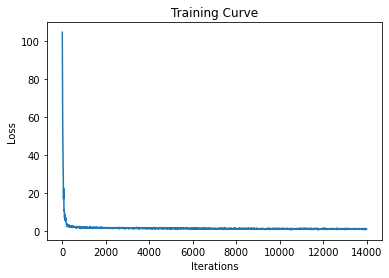

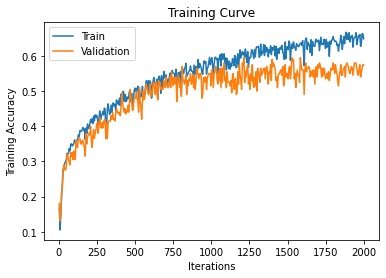

In [30]:
use_cuda = True
net = simpleANN()
model = train_network(net,train_loader,test_loader,num_epochs=2000,learning_rate=0.0001)

#### LSTM

In [16]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.5,batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # x = x.unsqueeze(0)
        # print("Input Shape",x.shape)
        # print(x.size)
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).float()).cuda()
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).float()).cuda()
        # print("Initial state shape:",h0.shape)
        out, _ = self.lstm(x, (h0, c0))
        # print("LSTM Output Shape:",out.shape)
        out = self.relu(self.fc1(torch.max(out, dim=1)[0]))
        # out = self.relu(self.fc1(out[:, -1, :]))
        out = self.fc(out) 
        return out

When training on LSTM's, we will be using only the MFCC features. Also, instead of averaging the mfcc per frame, we will use the entire set of coefficients instead.

In [14]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
features=[]
labels=[]
file_names = []
for g in tqdm(genres):
    for filename in os.listdir(f'/content/genres/{g}'):
        try:
          songname = f'/content/genres/{g}/{filename}'
          # print(songname)
          y, sr = librosa.load(songname, mono=True, duration=25)
          mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
          features.append(mfcc[...,np.newaxis])
          labels.append(g)
          file_names.append(filename)
        except (RuntimeError,IsADirectoryError):
          pass   

100%|██████████| 10/10 [01:12<00:00,  7.22s/it]


In [15]:
output= np.concatenate(features,axis=2)
output = output.transpose(2,1,0)
output.shape

(1000, 1077, 20)

In [16]:
x_train,x_test,y_train,y_test = train_test_split(output,labels,test_size = 0.3,stratify = labels)

In [17]:
encoded = {'pop':0,'jazz':1,'blues':2,'reggae':3,'classical':4,'metal':5,'country':6,'hiphop':7,'rock':8,'disco':9}
y_train = pd.Series(y_train).map(encoded)
y_test = pd.Series(y_test).map(encoded)

In [18]:
x_train.shape

(700, 1077, 20)

In [19]:
# Make training and validation dataset in format usable by dataloader

train = []
for i in range(len(x_train)):
    train.append((torch.Tensor(list(x_train[i,:,:])),y_train.values[i]))

valid = []
for i in range(len(x_test)):
    valid.append((torch.Tensor(list(x_test[i,:,:])),y_test.values[i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """


In [20]:
#Dataloader
train_loader = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=256, shuffle=True)

In [21]:
song,label = next(iter(train_loader))
song.shape

torch.Size([256, 1077, 20])

Training on Cuda
Epoch 0/99
----------
Epoch 1/99
----------
Epoch 2/99
----------
Epoch 3/99
----------
Epoch 4/99
----------
Epoch 5; Loss 2.257578; Train Acc 0.258571; Val Acc 0.263333
Epoch 5/99
----------
Epoch 6/99
----------
Epoch 7/99
----------
Epoch 8/99
----------
Epoch 9/99
----------
Epoch 10; Loss 2.162968; Train Acc 0.320000; Val Acc 0.350000
Epoch 10/99
----------
Epoch 11/99
----------
Epoch 12/99
----------
Epoch 13/99
----------
Epoch 14/99
----------
Epoch 15; Loss 1.931310; Train Acc 0.338571; Val Acc 0.353333
Epoch 15/99
----------
Epoch 16/99
----------
Epoch 17/99
----------
Epoch 18/99
----------
Epoch 19/99
----------
Epoch 20; Loss 1.753049; Train Acc 0.380000; Val Acc 0.380000
Epoch 20/99
----------
Epoch 21/99
----------
Epoch 22/99
----------
Epoch 23/99
----------
Epoch 24/99
----------
Epoch 25; Loss 1.645903; Train Acc 0.431429; Val Acc 0.380000
Epoch 25/99
----------
Epoch 26/99
----------
Epoch 27/99
----------
Epoch 28/99
----------
Epoch 29/99
-----

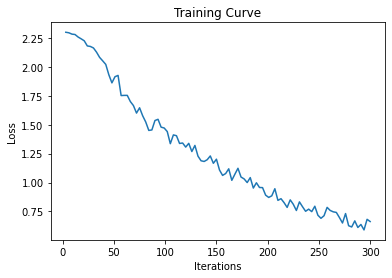

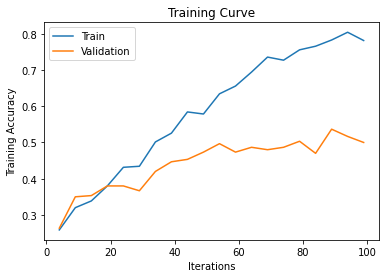

In [27]:
use_cuda = True
rnn = RNN(input_size=20, hidden_size=50, num_layers=2, num_classes=10)
CUDA_LAUNCH_BLOCKING=1
if use_cuda and torch.cuda.is_available():
  print("Training on Cuda")
  rnn.cuda()

model = train_network(rnn,train_loader,valid_loader,num_epochs=100,learning_rate=1e-3)

#### Training on 5 sec segments and augmented data

In [10]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
features=[]
labels=[]
file_names = []
for g in tqdm(genres):
    for filename in os.listdir(f'/content/data_seg_aug/{g}'):
        try:
          songname = f'/content/data_seg_aug/{g}/{filename}'
          # print(songname)
          y, sr = librosa.load(songname, mono=True, duration=25)
          mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
          features.append(mfcc[...,np.newaxis])
          labels.append(g)
          file_names.append(filename)
        except (RuntimeError,IsADirectoryError):
          pass   

100%|██████████| 10/10 [01:17<00:00,  7.74s/it]


In [11]:
output= np.concatenate(features,axis=2)
output = output.transpose(2,1,0)
output.shape

(5000, 216, 20)

In [12]:
x_train,x_test,y_train,y_test = train_test_split(output,labels,test_size = 0.3,stratify = labels)

In [13]:
encoded = {'pop':0,'jazz':1,'blues':2,'reggae':3,'classical':4,'metal':5,'country':6,'hiphop':7,'rock':8,'disco':9}
y_train = pd.Series(y_train).map(encoded)
y_test = pd.Series(y_test).map(encoded)

In [19]:
# Make training and validation dataset in format usable by dataloader

train = []
for i in range(len(x_train)):
    train.append((torch.Tensor(list(x_train[i,:,:])),y_train.values[i]))

valid = []
for i in range(len(x_test)):
    valid.append((torch.Tensor(list(x_test[i,:,:])),y_test.values[i]))

train_loader = torch.utils.data.DataLoader(train, batch_size=512, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=512, shuffle=True)

Training on Cuda
Epoch 0/499
----------
Epoch 1/499
----------
Epoch 2/499
----------
Epoch 3/499
----------
Epoch 4/499
----------
Epoch 5; Loss 2.294484; Train Acc 0.143714; Val Acc 0.136667
Epoch 5/499
----------
Epoch 6/499
----------
Epoch 7/499
----------
Epoch 8/499
----------
Epoch 9/499
----------
Epoch 10; Loss 2.286360; Train Acc 0.175714; Val Acc 0.170667
Epoch 10/499
----------
Epoch 11/499
----------
Epoch 12/499
----------
Epoch 13/499
----------
Epoch 14/499
----------
Epoch 15; Loss 2.268953; Train Acc 0.197714; Val Acc 0.180667
Epoch 15/499
----------
Epoch 16/499
----------
Epoch 17/499
----------
Epoch 18/499
----------
Epoch 19/499
----------
Epoch 20; Loss 2.243893; Train Acc 0.237143; Val Acc 0.222667
Epoch 20/499
----------
Epoch 21/499
----------
Epoch 22/499
----------
Epoch 23/499
----------
Epoch 24/499
----------
Epoch 25; Loss 2.193815; Train Acc 0.301714; Val Acc 0.276000
Epoch 25/499
----------
Epoch 26/499
----------
Epoch 27/499
----------
Epoch 28/499

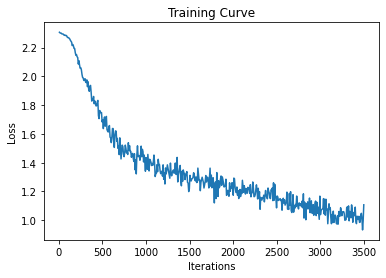

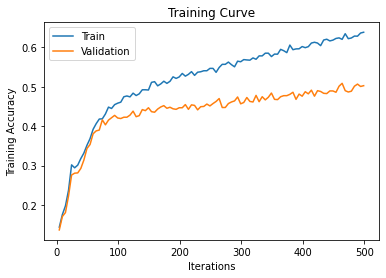

In [21]:
use_cuda = True
rnn = RNN(input_size=20, hidden_size=50, num_layers=2, num_classes=10)
CUDA_LAUNCH_BLOCKING=1
if use_cuda and torch.cuda.is_available():
  print("Training on Cuda")
  rnn.cuda()

model = train_network(rnn,train_loader,valid_loader,num_epochs=500,learning_rate=1e-4)

### Progress Report Summary and Next Steps

So far the focus of the project has been extracting various features from the audio data and trying different algotihms to compare performance among themselves and more traditional methods such as SVM. 

Despite augmentation, segmentation and hyper parameter tuning the models have a tendency to overfit on the training dataset. In order to resolve this our next approach would be to generete feature representations of the audio data using some sort of auto encoders and then use these for training our model. MFCC's have been traditionally used as features for audio data, however our initial results using a generated feature represntation have been much more promising.

For our demonstration, we intend on using recently released music which we can parse either through the youtube_dl library or pass manually and conduct genre classification.